In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [3]:
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, 
                                                   clipvalue=1.0, 
                                                   decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, 
                      loss='binary_crossentropy')

In [4]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [5]:
gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, 
                                         clipvalue=1.0, 
                                         decay=1e-8)
gan.compile(optimizer=gan_optimizer, 
            loss='binary_crossentropy')

In [6]:
import os

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [7]:
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)
).astype('float32') / 255.

In [8]:
from tensorflow.keras.preprocessing import image

iterations = 10000
batch_size = 20
save_dir = '../datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)), 
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print(f'discriminator loss at step {step} : {d_loss}')
        print(f'adversarial loss at step {step} : {a_loss}')
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_flog' + str(step) + '.png'))

discriminator loss at step 0 : 0.6865614056587219
adversarial loss at step 0 : 0.7056264877319336
discriminator loss at step 100 : 0.7256008386611938
adversarial loss at step 100 : 0.7716291546821594
discriminator loss at step 200 : 0.6915867924690247
adversarial loss at step 200 : 0.7833408117294312
discriminator loss at step 300 : 0.6794959306716919
adversarial loss at step 300 : 0.7829461097717285
discriminator loss at step 400 : 0.6905885934829712
adversarial loss at step 400 : 0.7563334703445435
discriminator loss at step 500 : 0.6988344788551331
adversarial loss at step 500 : 0.724582314491272
discriminator loss at step 600 : 0.6981085538864136
adversarial loss at step 600 : 1.6032540798187256
discriminator loss at step 700 : 0.6876168251037598
adversarial loss at step 700 : 0.8021127581596375
discriminator loss at step 800 : 0.6845447421073914
adversarial loss at step 800 : 0.7242443561553955
discriminator loss at step 900 : 0.696236789226532
adversarial loss at step 900 : 0.749

discriminator loss at step 8000 : 0.6753329038619995
adversarial loss at step 8000 : 0.726405918598175
discriminator loss at step 8100 : 0.6893519759178162
adversarial loss at step 8100 : 0.800564169883728
discriminator loss at step 8200 : 0.6853720545768738
adversarial loss at step 8200 : 0.8352113962173462
discriminator loss at step 8300 : 0.7028853893280029
adversarial loss at step 8300 : 1.1056787967681885
discriminator loss at step 8400 : 0.706220269203186
adversarial loss at step 8400 : 0.38379257917404175
discriminator loss at step 8500 : 0.6752344965934753
adversarial loss at step 8500 : 0.7700958251953125
discriminator loss at step 8600 : 0.6675722599029541
adversarial loss at step 8600 : 0.8761075139045715
discriminator loss at step 8700 : 0.6855596303939819
adversarial loss at step 8700 : 0.7966256737709045
discriminator loss at step 8800 : 0.7138324975967407
adversarial loss at step 8800 : 0.8891746401786804
discriminator loss at step 8900 : 0.6699126362800598
adversarial l

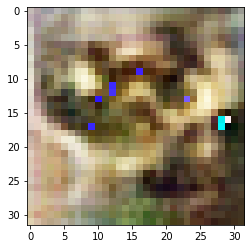

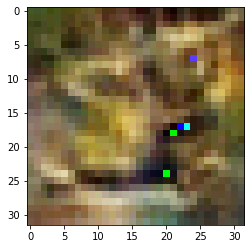

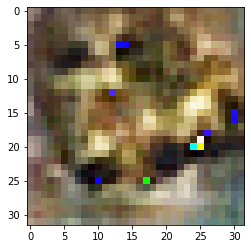

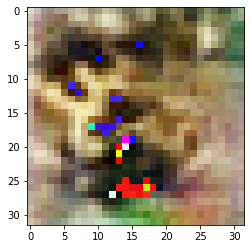

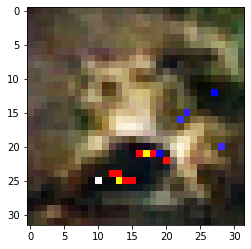

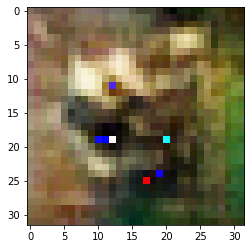

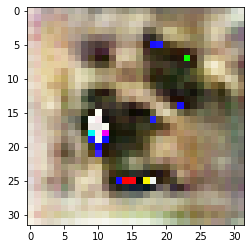

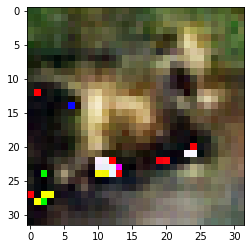

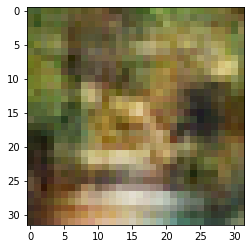

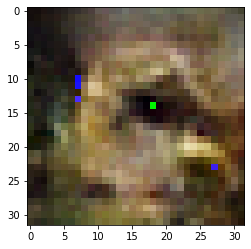

In [9]:
import matplotlib.pyplot as plt

random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)

plt.show()